# Анализ оттока клиентов сети фитнес-центров  «Культурист-датасаентист»

В нашем распоряжении csv-файл, предоставленный заказчиком «Культурист-датасаентист». В файле данные клиентов фитнес-центров, информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента, информация об оттоке клиентов.   

**Необходимо провести анализ и подготовить план действий по удержанию клиентов:**
* научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
* сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
* проанализировать основные признаки, наиболее сильно влияющие на отток;
* сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:   
1) выделить целевые группы клиентов;   
2) предложить меры по снижению оттока;   
3) определить другие особенности взаимодействия с клиентами

* * *

## Общий функционал для анализа данных

In [1]:
#импорт необходимых библиотек
import pandas as pd
import numpy as np
import datetime as dt
import math as mth
from scipy import stats as st
import statistics

import warnings
warnings.filterwarnings(action='ignore')

from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly import graph_objects as go
%matplotlib inline

import re

from io import BytesIO
import requests


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.ensemble import RandomForestClassifier

from scipy.cluster.hierarchy import dendrogram, linkage

from sklearn.cluster import KMeans

In [2]:
# функция проверяет наличие явных дубликатов в датасете, участвуют столбцы columns
def check_duplicates(data, columns):
    number_duplicates = data.duplicated(columns).sum()
    if number_duplicates == 0:
        print("Явных дубликатов нет")
    else:
        print(f"Явные дубликаты есть: {number_duplicates} шт.")

In [3]:
# функция выводит основную информацию о датасете data для проверки первичных данных
def check_data(data):
    #общая информация о датасете
    data.info()
    #первые 10 строк датасета
    display(data.head(10))
    print()
    # проверим на наличие дубликатов
    check_duplicates(data,data.columns)
    print()
    #размер таблицы
    print(f'В таблице {data.shape[0]} строк, {data.shape[1]} столбцов')

## Изучение общей информации

In [4]:
# получаем таблицу(датасет) с данными о заведениях в Москве
try:
    data = pd.read_csv('/datasets/gym_churn.csv')
except:
    data = pd.read_csv('gym_churn.csv')

In [5]:
#получим общую информацию о датасете
check_data(data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0
5,1,1,0,0,1,1,1,34,450.743960,1.0,3,2.623477,2.637007,0
6,1,1,1,1,0,6,1,32,94.266389,6.0,2,1.138941,1.277242,0
7,0,1,0,0,1,1,0,30,217.786641,1.0,0,1.213502,1.049387,1
8,1,1,1,1,1,1,1,23,45.409909,1.0,1,1.106239,1.059333,0
9,0,1,0,0,1,1,0,31,65.310836,1.0,11,1.810852,1.951368,0



Явных дубликатов нет

В таблице 4000 строк, 14 столбцов


Согласно документации:  

**Данные клиента за предыдущий до проверки факта оттока месяц:**
* gender — пол;
* Near_Location — проживание или работа в районе, где находится фитнес-центр;
* Partner — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
Promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
* Phone — наличие контактного телефона;
* Age — возраст;
* Lifetime — время с момента первого обращения в фитнес-центр (в месяцах).   

**Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:**
* Contract_period — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
* Month_to_end_contract — срок до окончания текущего действующего абонемента (в месяцах);
* Group_visits — факт посещения групповых занятий;
* Avg_class_frequency_total — средняя частота посещений в неделю за все время с начала действия абонемента;
* Avg_class_frequency_current_month — средняя частота посещений в неделю за предыдущий месяц;
* Avg_additional_charges_total — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.
* Churn — факт оттока в текущем месяце.

In [6]:
# переведем названия колонок в нижний регистр
data.columns = data.columns.str.lower()
data.columns

Index(['gender', 'near_location', 'partner', 'promo_friends', 'phone',
       'contract_period', 'group_visits', 'age',
       'avg_additional_charges_total', 'month_to_end_contract', 'lifetime',
       'avg_class_frequency_total', 'avg_class_frequency_current_month',
       'churn'],
      dtype='object')

### Вывод

Часть колонок датасета содержит данные о клиенте, другая - информацию на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента. И есть колонка с флагом-фактом оттока в текущем месяце. Посмотрели общую информацию о датасете и выяснили, что:
* В датасете содержится 4000 строк, 14 столбцов.
* Явных дубликатов нет
* Пропущенных значений нет
* Колонок с категориальными признаками нет
* Названия колонок написаны не в нижнем регистре. Для удобства перевели их в нижний регистр. 

Данные хорошего качества, наблюдений порядка тысяч. Что является достаточным для применения машинного обучения для решения поставленной задачи.

## Исследовательский анализ данных

*Ранее упоминалось, что пропущенных значений в датасете нет.   
Посмотрим на средние значения и стандартные отклонения признаков.*

In [7]:
#получим информацию о значениях датасета
data.describe().T[['mean','std']]

,mean,std
gender,0.510250,0.499957
near_location,0.845250,0.361711
partner,0.486750,0.499887
promo_friends,0.308500,0.461932
phone,0.903500,0.295313
contract_period,4.681250,4.549706
group_visits,0.412250,0.492301
age,29.184250,3.258367
avg_additional_charges_total,146.943728,96.355602
month_to_end_contract,4.322750,4.191297


Средние значения и стандартные отклонения одного порядка, что говорит об остутствии выбросов

*Посмотрим на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался*

In [8]:
data.groupby('churn').mean().T

churn,0,1
gender,0.510037,0.510839
near_location,0.873086,0.768143
partner,0.534195,0.355325
promo_friends,0.353522,0.183789
phone,0.903709,0.902922
contract_period,5.747193,1.728558
group_visits,0.464103,0.268615
age,29.976523,26.989632
avg_additional_charges_total,158.445715,115.082899
month_to_end_contract,5.283089,1.662582


По средним значениям признаков можно предположить, что те, кто ушел в отток меньше вовлечны в процесс посещения фитнес-центров: дальше живут(работают), меньше получают абонементов от партнеров сети фитнес-центров и меньше покупают их по совету друзей, меньше тратят денег в фитнес-центре, реже посещают его. Приэтом, судя по среднему значению lifetime, бросают новички, которые отходили в центр чуть меньше месяца.

*Построим распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток)*

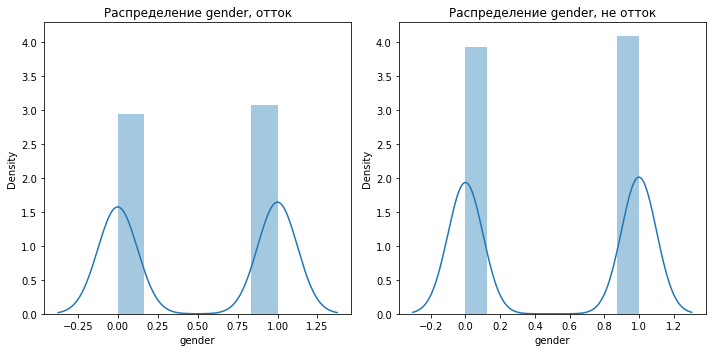

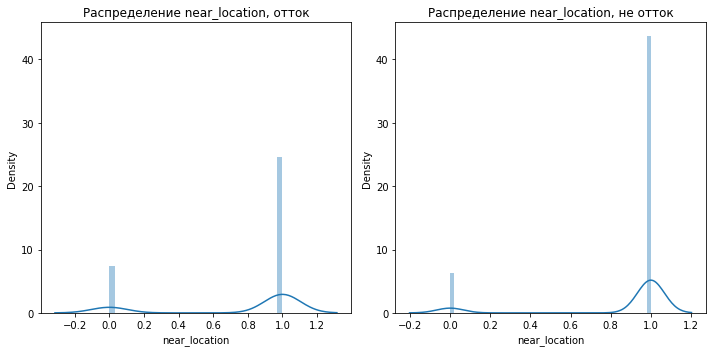

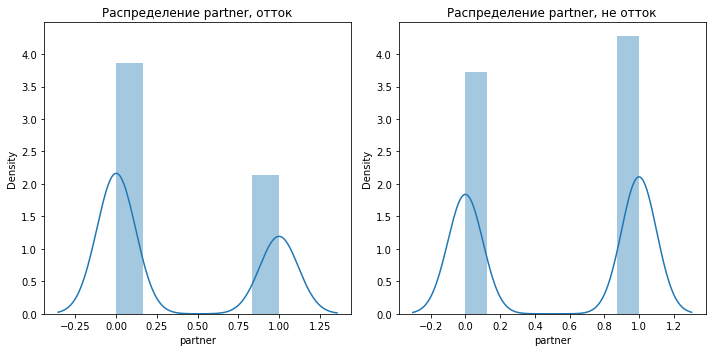

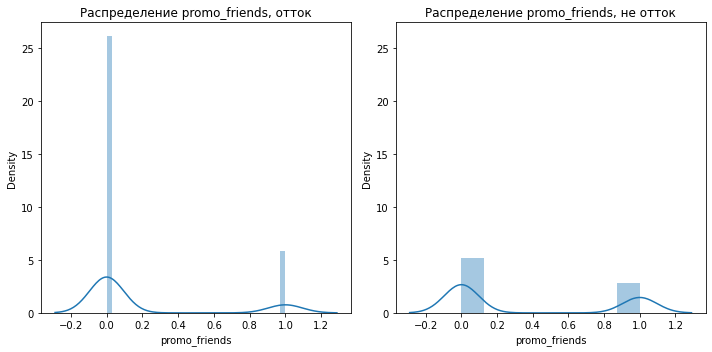

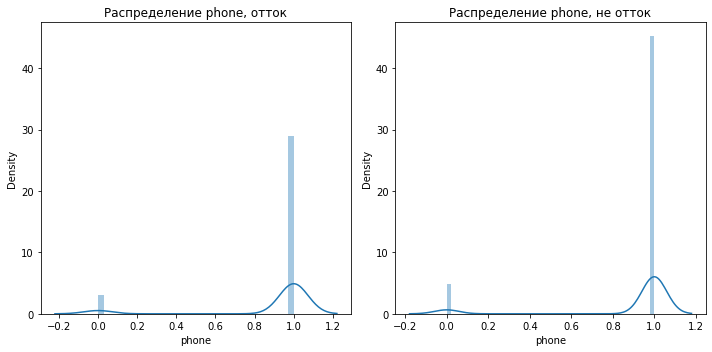

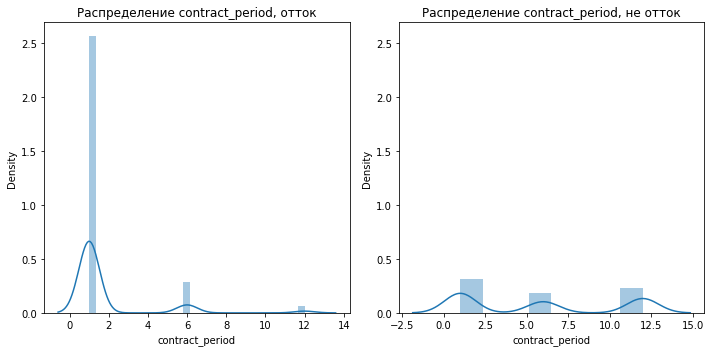

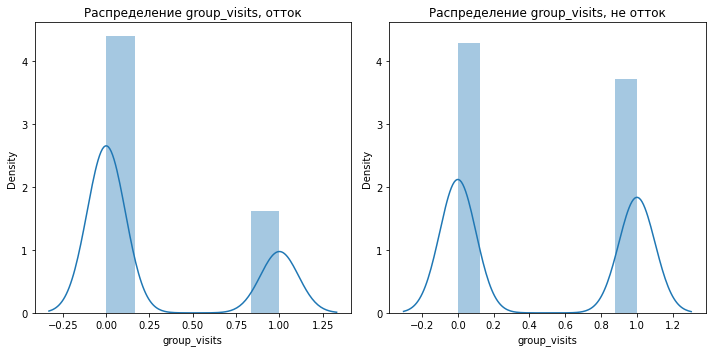

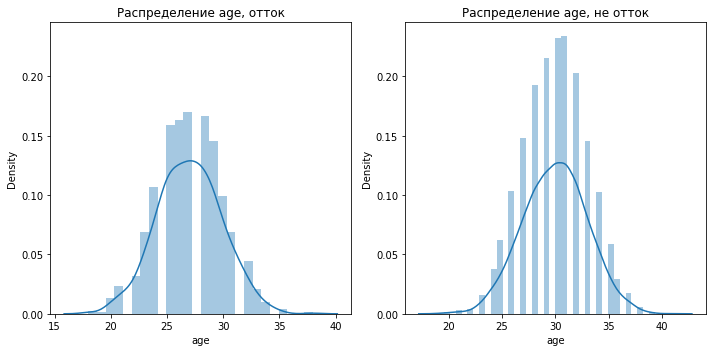

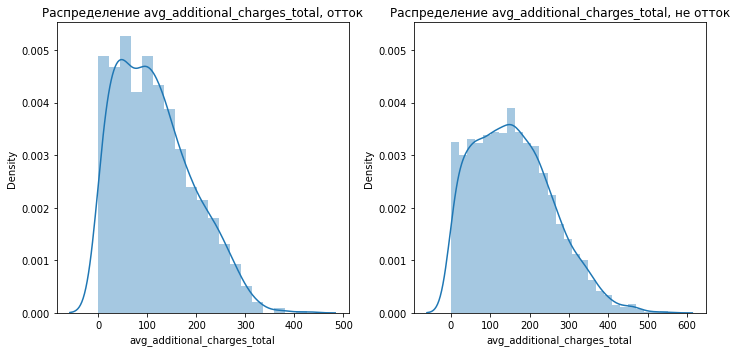

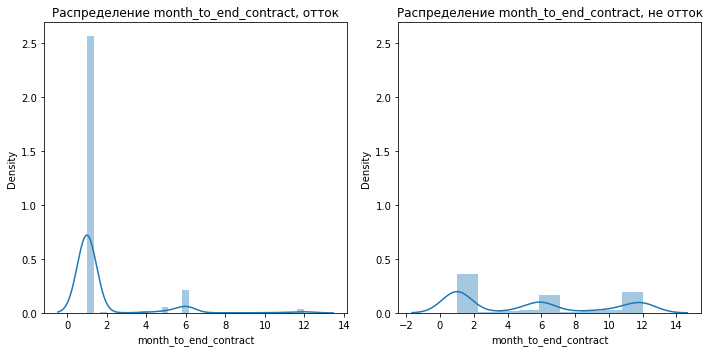

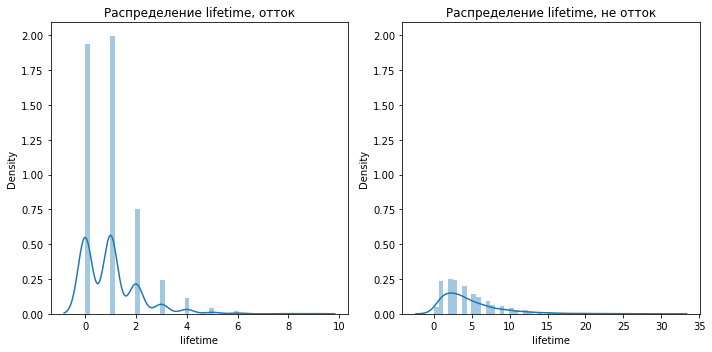

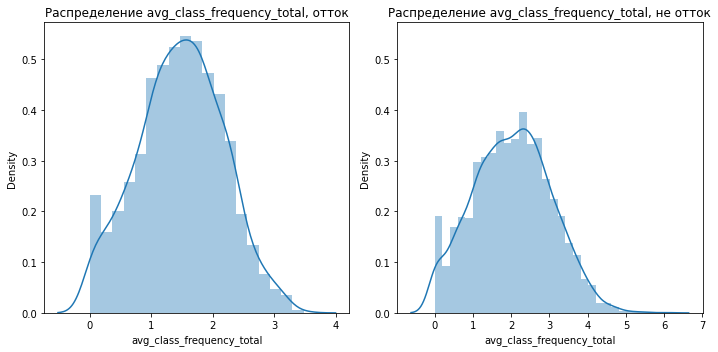

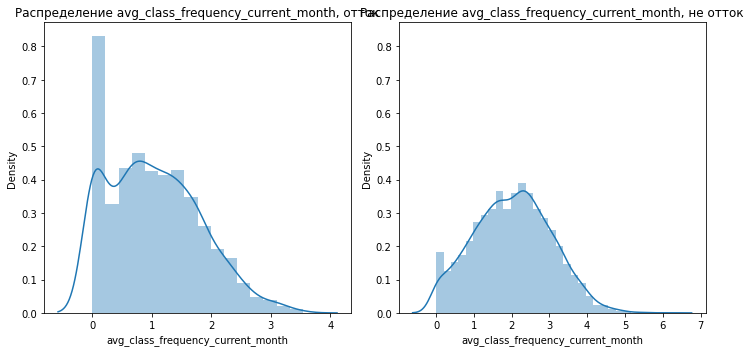

In [9]:
for column in data.columns:
    if column != 'churn': 
        plt.figure(figsize=(10, 5))
        # график распределения column для тех, кто в оттоке 
        ax1 = plt.subplot(1, 2, 1) 
        sns.distplot(data[data['churn'] == 1][column], ax = ax1)
        plt.title(f"Распределение {column}, отток")
        # график распределения column для тех, кто не в оттоке 
        ax2 = plt.subplot(1, 2, 2, sharey=ax1) 
        sns.distplot(data[data['churn']==0][column], ax = ax2)
        plt.title(f"Распределение {column}, не отток")
        plt.tight_layout()
        plt.show()
        print()

*Построим матрицу корреляций и отобразим её*

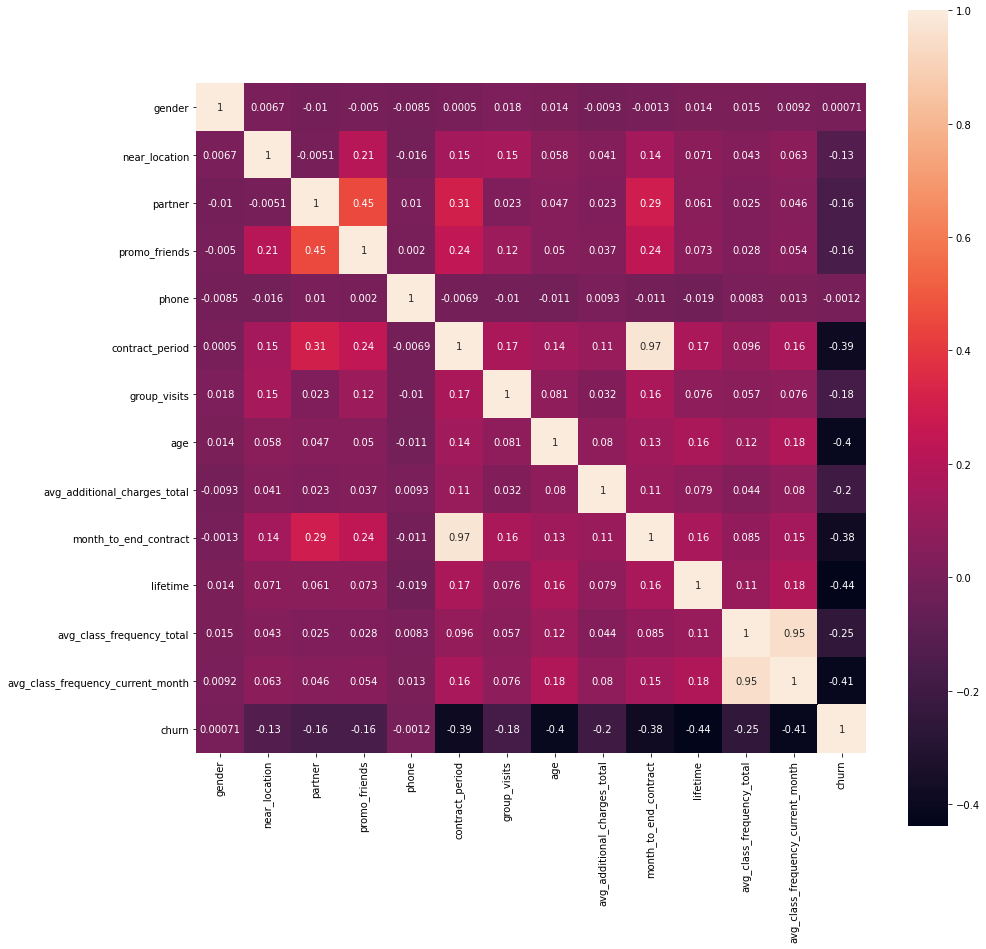

In [10]:
# корреляционная матрица
corr_m = data.corr()

# нарисуем heatmap
plt.figure(figsize = (15,15))
sns.heatmap(corr_m,square = True,annot = True)
plt.show()

Среди признаков есть сильно коррелирующие: contact_period и month_to_end_contract, avg_class_frequency_current_month и avg_class_frequency_total. В каждой паре признаков удалим один для ликвидации мультиколлинеарности признаков.

In [11]:
data = data.drop(['avg_class_frequency_total','month_to_end_contract'], axis=1)

In [12]:
data.shape

(4000, 12)

### Вывод

Провели исследовательский анализ данных и выяснили, что:
* Пропущенных значений нет
* Средние значения и стандартные отклонения признаков одного порядка, что говорит об остутствии выбросов
* По средним значениям признаков можно предположить, что те, кто ушел в отток меньше вовлечны в процесс посещения фитнес-центров: дальше живут(работают), меньше получают абонементов от партнеров сети фитнес-центров и меньше покупают их по совету друзей, меньше тратят денег в фитнес-центре, реже посещают его. Приэтом, судя по среднему значению lifetime, бросают новички, которые отходили в центр чуть меньше месяца.
* Коэффициенты корреляции с целевой переменной churn больше всего у признаков lifetime, age, avg_class_frequency_current_month, contact_period, month_to_end_contract, по модулю около 0.4. Можно предположить, что эти признаки больше всего влияют на отток клиентов.
* Среди признаков были сильно коррелирующие: contact_period и month_to_end_contract, avg_class_frequency_current_month и avg_class_frequency_total. Удалили столбцы с признаками avg_class_frequency_total, month_to_end_contract

## Построение модели бинарной классификации клиентов

*Построим две модели бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце, линейной регрессией и случайным лесом*

In [13]:
# посмотрим, как соотносятся классы набора данных
print('Соотношение классов:\n', data['churn'].value_counts())

Соотношение классов:
 0    2939
1    1061
Name: churn, dtype: int64


In [14]:
# определим функцию, которая будет выводить наши метрики
def print_all_metrics(y_true, y_pred, title='Метрики классификации'):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))
    print('\tF1: {:.2f}'.format(f1_score(y_true, y_pred)))

In [15]:
# разделим наши данные на признаки (матрица X) и целевую переменную (y)
X = data.drop('churn', axis=1)
y = data['churn']

In [16]:
# разделяем модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0
)

In [17]:
# обучим StandartScaler на обучающей выборке
scaler = StandardScaler()
scaler.fit(X_train)
# Преобразуйте обучающий и валидационные наборы данных
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

In [18]:
# зададим алгоритм для модели логистической регрессии
lr_model = LogisticRegression(random_state=0)
# обучим модель
lr_model.fit(X_train_st, y_train)
# воспользуемся уже обученной моделью, чтобы сделать прогнозы
lr_predictions = lr_model.predict(X_test_st)
# выведем все метрики
print_all_metrics(
    y_test,
    lr_predictions,
    title='Метрики для модели логистической регрессии:'
)

Метрики для модели логистической регрессии:
	Accuracy: 0.90
	Precision: 0.79
	Recall: 0.82
	F1: 0.81


In [19]:
# зададим алгоритм для новой модели на основе алгоритма случайного леса
rf_model = RandomForestClassifier(n_estimators=100, random_state=0) 
# обучим модель случайного леса
rf_model.fit(X_train_st, y_train)
# воспользуемся уже обученной моделью, чтобы сделать прогнозы
rf_predictions = rf_model.predict(X_test_st)
# выведем все метрики
print_all_metrics(
    y_test,
    rf_predictions,
    title='Метрики для модели случайного леса:'
)

Метрики для модели случайного леса:
	Accuracy: 0.90
	Precision: 0.81
	Recall: 0.75
	F1: 0.78


Узнаем, какие признаки сильнеее всего влияют на целевую переменную

In [20]:
df = pd.DataFrame({'feature' : X.columns, 'importance' : abs(lr_model.coef_)[0]})
print(df.sort_values(by='importance', ascending = False))

                              feature  importance
9                            lifetime    3.922703
5                     contract_period    1.340862
10  avg_class_frequency_current_month    1.326734
7                                 age    1.102478
8        avg_additional_charges_total    0.582020
6                        group_visits    0.378909
3                       promo_friends    0.244437
4                               phone    0.088119
1                       near_location    0.083076
2                             partner    0.069225
0                              gender    0.050670


### Вывод

Построили две модели бинарной классификации с помощью линейной регрессии и случайного леса, для каждой из моделей посчитаны метрики. Выяснили что:
* Accuracy в обоих случаях одинакова
* Precision логистической регресии на 0.02 меньше, чем у случайного дерева
* Recall логистической регресии на 0.07 больше, чем у случайного дерева
* Сводная метрика F1 больше у логистической прогрессии

Следовательно, модель, обученная с помощью логистической регрессии, показала себя лучше, чем модель, обученная случайным деревом.

Выяснили, что признаки lifetime, contract_period, avg_class_frequency_current_month, age больше всего влияют на целевую переменную churn

## Кластеризация клиентов

In [21]:
# стандартизируем данные
sc = StandardScaler()
X_sc = sc.fit_transform(X)

In [22]:
linked = linkage(X_sc, method = 'ward') 

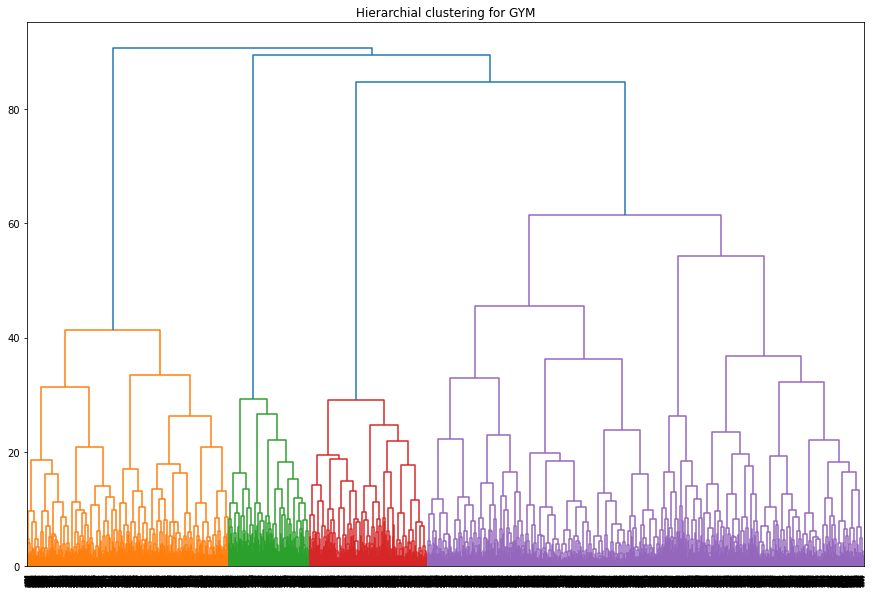

In [23]:
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Hierarchial clustering for GYM')
plt.show() 

Предложенное оптимальное число кластеров - 5

In [24]:
n_clusters = 5

In [25]:
# задаём число кластеров, равное 5, и фиксируем значение random_state для воспроизводимости результата
km = KMeans(n_clusters=n_clusters, random_state=0)
# применяем алгоритм к данным и формируем вектор кластеров 
labels = km.fit_predict(X_sc)
data['cluster'] = labels

Найдем средние значения признаков для каждого кластера

In [26]:
clusters_table = data.groupby(['cluster']).mean().T
clusters_table

cluster,0,1,2,3,4
gender,0.496447,0.500000,0.500940,0.534260,0.523316
near_location,0.995939,0.000000,1.000000,0.996028,0.862694
partner,0.892386,0.489247,0.217105,0.379345,0.471503
promo_friends,1.000000,0.078853,0.072368,0.009930,0.305699
phone,1.000000,1.000000,1.000000,1.000000,0.000000
contract_period,6.922843,2.994624,2.010338,6.208540,4.777202
group_visits,0.524873,0.232975,0.277256,0.538232,0.427461
age,29.606091,28.679211,27.583647,30.699106,29.297927
avg_additional_charges_total,153.424651,137.125763,119.339956,176.259567,144.208179
lifetime,4.283249,2.974910,1.922932,5.415094,3.940415


Можно заметить, что вектора-кластеры независимы друг от друга: нет хотя бы двух похожих кластеров.

Построим распределения признаков для кластеров

Распределения gender


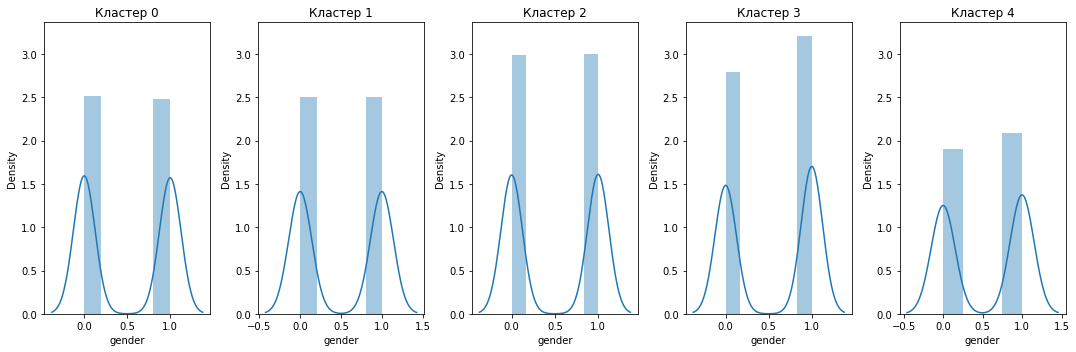


Распределения near_location


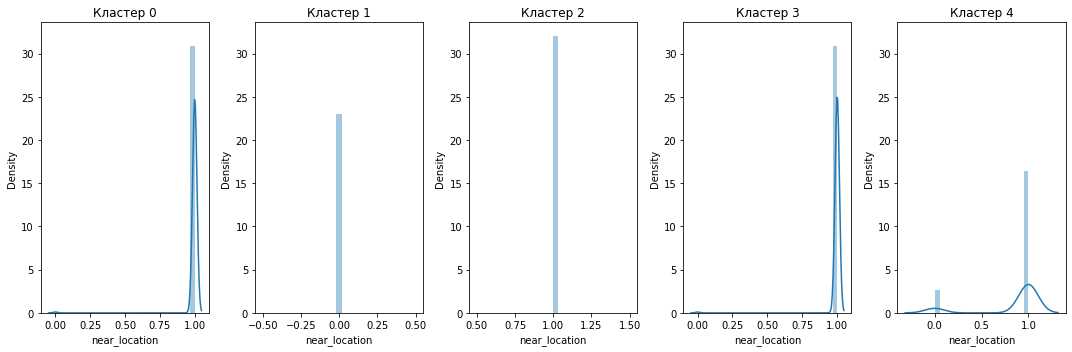


Распределения partner


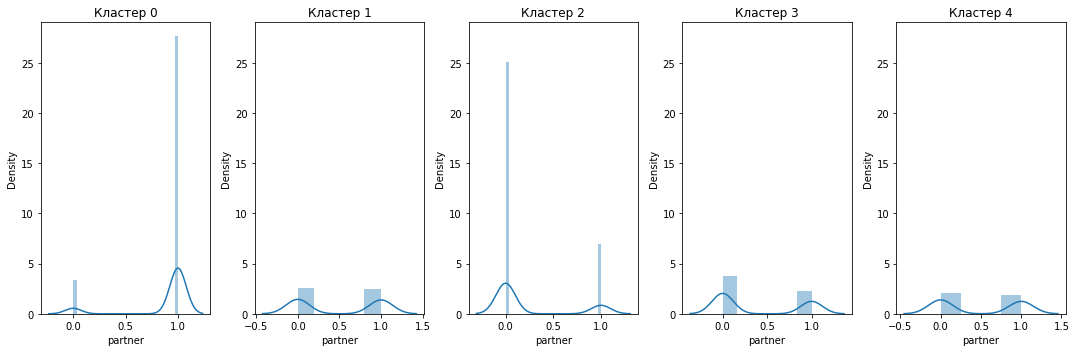


Распределения promo_friends


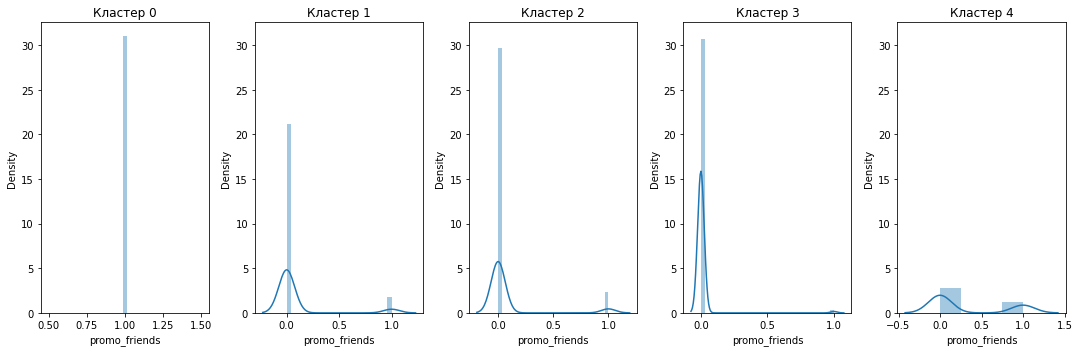


Распределения phone


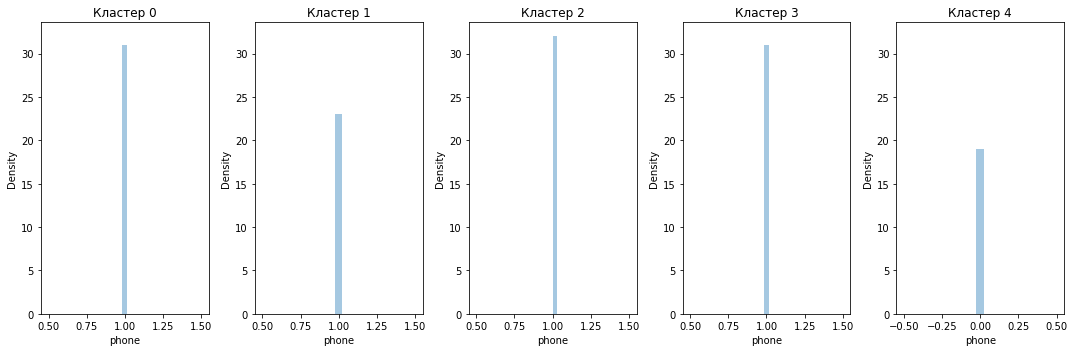


Распределения contract_period


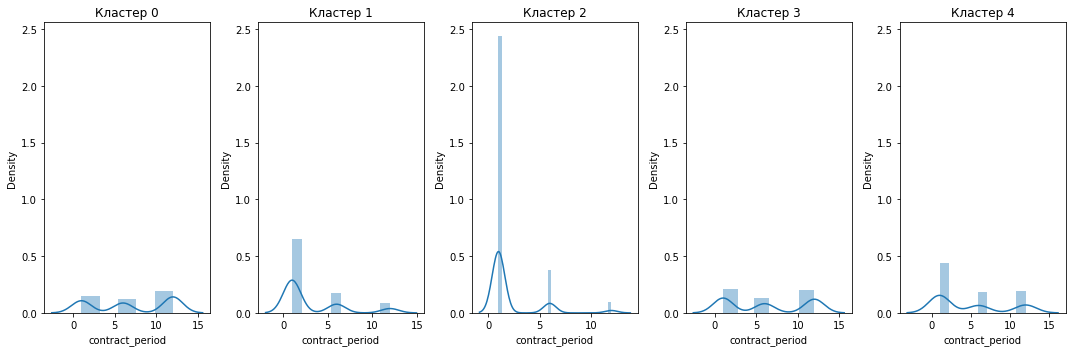


Распределения group_visits


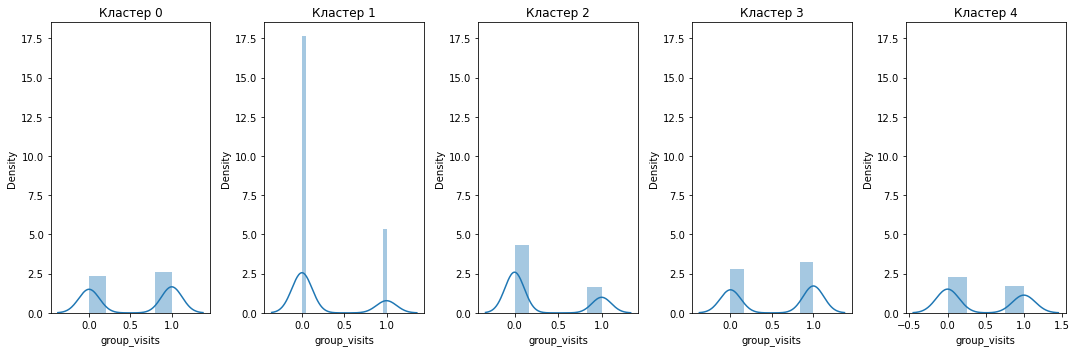


Распределения age


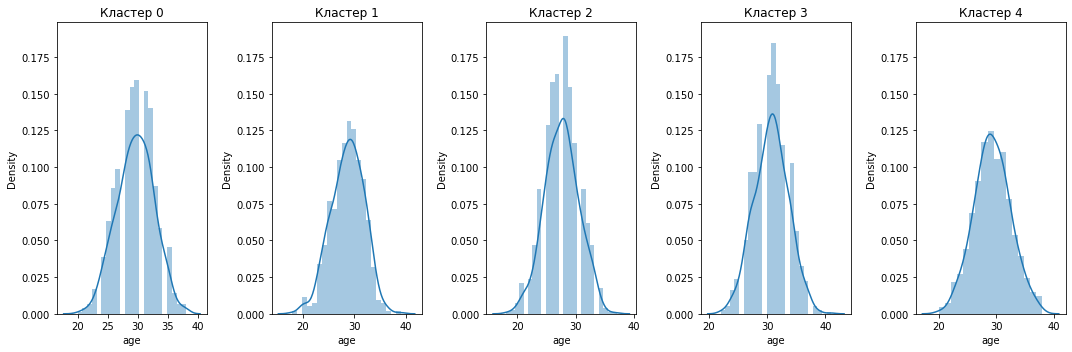


Распределения avg_additional_charges_total


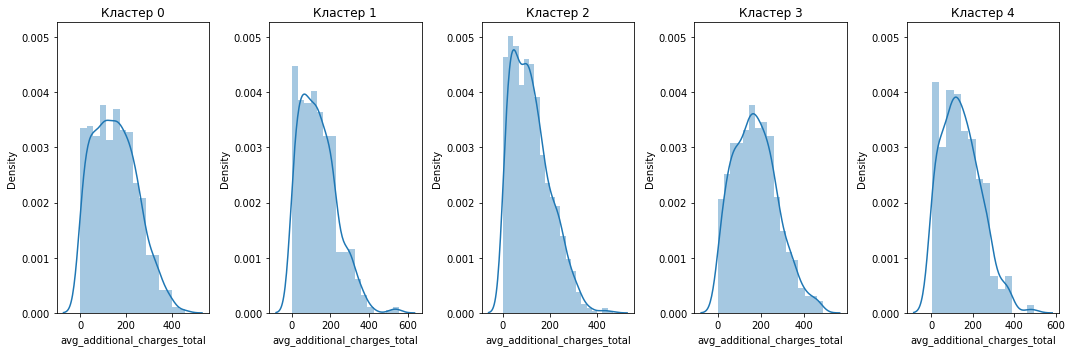


Распределения lifetime


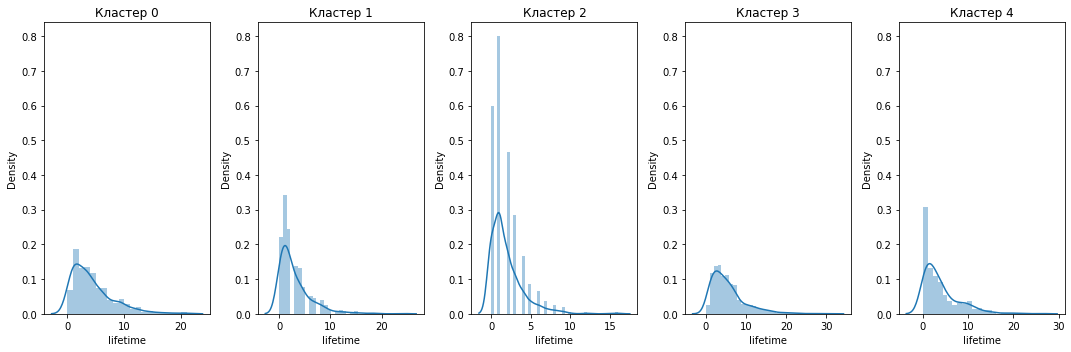


Распределения avg_class_frequency_current_month


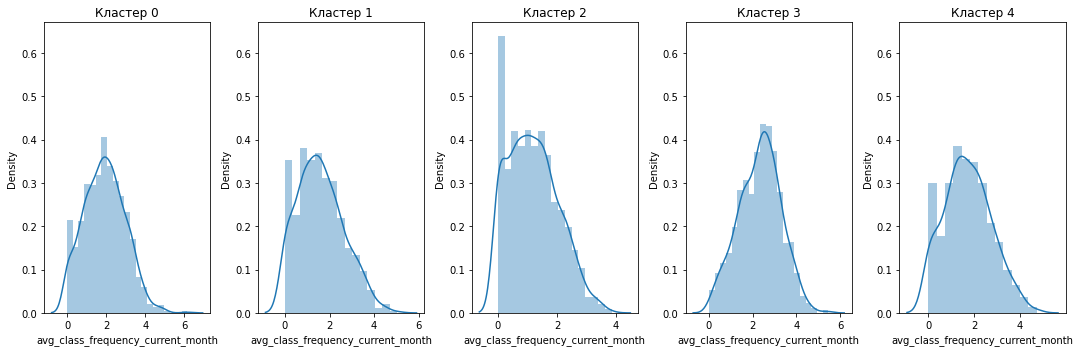


Распределения churn


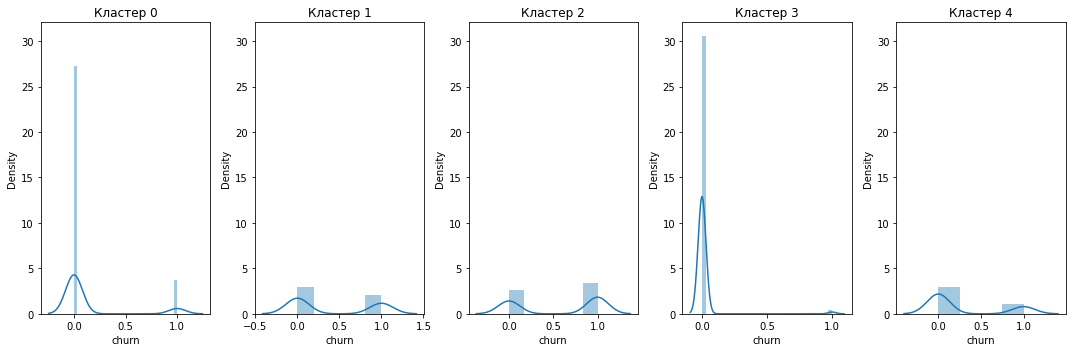

In [27]:
for column in data.columns:
    if column != 'cluster':
        print(f"Распределения {column}")
        plt.figure(figsize=(15, 5))
        ax_old = plt.subplot(1, 5, 1)
        for i in range(5):
            ax_old = plt.subplot(1, 5, i+1, sharey=ax_old) 
            sns.distplot(data[data['cluster'] == i][column], ax = ax_old)
            plt.title(f"Кластер {i}") 
        plt.tight_layout()
        plt.show()
        print()


Для каждого кластера посчитаем долю оттока

In [28]:
clusters = data.groupby('cluster', as_index=False)['churn'].mean().rename(columns={'churn':'part_of_churn'})
# отсортируем по убыванию доли оттока
clusters = clusters.sort_values('part_of_churn')
clusters.style.format({'part_of_churn': '{:.2%}'})

,cluster,part_of_churn
3,3,1.49%
0,0,11.98%
4,4,26.68%
1,1,40.32%
2,2,56.39%


Кластеры 1, 2 - склонны к оттоку, 0, 3, 4 - нет.

### Вывод

Была проведена кластеризация клиентов, получилось 5 кластеров с нумерацией от 0 до 4. Кластеры 1, 2 больше всего склонны к оттоку. Анализируя определяющие признаки надежных кластеров, можно определить наиболее удачные значения этих признаков:
* lifetime больше 4 месяцев
* avg_class_frequency_current_month примерно 2 раза в неделю
* contract_period  6 месяцев

 ## Вывод

От заказчика «Культуриста-датасаентиста»  был получен файл с данными клиентов фитнес-центров, информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента, информация об оттоке клиентов.   
В резульате анализа данных были построены две модели бинарной классификации: линейная регрессия и случайный лес. В результате сравнения метрик моделей лучше себя показала линейная регрессия. Определили признаки наиболее влияющие на отток клиентов:
* lifetime
* contract_period
* avg_class_frequency_current_month

Далее была проведена кластеризация клиентов. Были получены 5 кластеров с нумерацией от 0 до 4. Кластеры 3, 0, 4 показали себя надежными и не предрасположенными к оттоку. Анализируя значения их признаков, можно дать следующие рекомендации по удержанию клиентов:
* Клиентам - новичкам, которые не так давно обратились в фитнес-центр, предлагать бонусы, оповещать о новых программах и возможностях 
* Стремиться продавать абонементы на 6 месяцев и более
* Поощрять посещения клиентов более одного раза в неделю: рассказывать о группповых занятиях, новинках, бонусах, скмдках на дополнительные услуги в случае посещения фитнес-центра 2 раза в неделю и более, делать гибкое расписание занятий